# Autoencoders

> Autoencoders

Adapted from:
- https://youtu.be/0Hi2r4CaHvk?si=GA9KaGAnGOlS_NJO&t=3568

In [1]:
# |default_exp autoencoders

In [2]:
# |export
from copy import copy
from typing import Mapping

import fastcore.all as fc
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as T
from datasets import load_dataset
from torch import nn, optim, tensor
from torch.utils.data import DataLoader, default_collate
from torcheval.metrics import Mean

from slowai.convs import conv, def_device, fashion_mnist, to_device
from slowai.datasets import show_image, show_images

Autoencoders learn a bottleneck representation that can be "reversed" to reconstruct the original image.

![](https://miro.medium.com/v2/resize:fit:600/1*nqzWupxC60iAH2dYrFT78Q.png)

Typically, they are not used on their own but are used to produce compressed representations.

We've seen how a convolutional neural network can produce a simple representation of an image: that is, the categorical probability distribution over all the fashion classes. How do reverse this process to reconstruct the original image.

Transpose or "Stride $\frac{1}{2}$"  convolutions work, but this notebook focuses on the [nearest neighbor upsampling](https://pytorch.org/docs/stable/generated/torch.nn.UpsamplingNearest2d.html). This upsamples the activations from the previous layer and applies a convolutional layer to restore detail.

In [3]:
# |export
def deconv(c_in, c_out, ks=3, act=True):
    layers = [
        nn.UpsamplingNearest2d(scale_factor=2),
        nn.Conv2d(c_in, c_out, stride=1, kernel_size=ks, padding=ks // 2),
    ]
    if act:
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

We need to modify the `fit` function because the loss function is no longer of the label.

In [4]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, tqdm_=False):
    """Modified fit function for reconstruction tasks"""
    progress = tqdm if tqdm_ else lambda x: x
    for epoch in range(epochs):
        model.train()
        trn_loss, trn_count = 0.0, 0
        for xb, _ in progress(train_dl):
            xb = to_device(xb)
            loss = loss_func(model(xb), xb)  # 👈
            bs, *_ = xb.shape
            trn_loss += loss.item() * bs
            trn_count += bs
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tst_loss, tot_acc, tst_count = 0.0, 0.0, 0
            for xb, _ in progress(valid_dl):
                xb = to_device(xb)
                pred = model(xb)
                bs, *_ = xb.shape
                tst_count += bs
                tst_loss += loss_func(pred, xb).item() * bs

        print(
            f"{epoch=}: trn_loss={trn_loss / trn_count:.3f}, tst_loss={tst_loss / tst_count:.3f}"
        )

In [5]:
def get_model():
    # input.shape[:2] == 28x28
    return nn.Sequential(
        nn.ZeroPad2d(padding=2),  # 32x32
        conv(1, 2),  # 16x16
        conv(2, 4),  # 8x8
        conv(4, 8),  # 4x4
        deconv(8, 4),  # 8x8
        deconv(4, 2),  # 16x16
        deconv(2, 1, act=False),  # 32x32
        nn.ZeroPad2d(padding=-2),  # 28x28
        nn.Sigmoid(),
    ).to(def_device)


autoencoder = get_model()
autoencoder

Sequential(
  (0): ZeroPad2d((2, 2, 2, 2))
  (1): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Sequential(
    (0): UpsamplingNearest2d(scale_factor=2.0, mode='nearest')
    (1): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
  )
  (5): Sequential(
    (0): UpsamplingNearest2d(scale_factor=2.0, mode='nearest')
    (1): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
  )
  (6): Sequential(
    (0): UpsamplingNearest2d(scale_factor=2.0, mode='nearest')
    (1): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (7): ZeroPad2d((-2, -2, -2, -2))
  (8): Sigmoid()
)

In [6]:
with fashion_mnist() as (_, tst_dl):
    xb, _ = next(iter(tst_dl))

In [7]:
assert xb.shape == autoencoder(xb.to(def_device)).shape

In [8]:
model = get_model()
with fashion_mnist() as dls:
    opt = optim.AdamW(model.parameters(), lr=0.01)
    fit(10, model, F.mse_loss, opt, *dls)

epoch=0: trn_loss=0.058, tst_loss=0.027
epoch=1: trn_loss=0.026, tst_loss=0.025
epoch=2: trn_loss=0.025, tst_loss=0.024
epoch=3: trn_loss=0.024, tst_loss=0.023
epoch=4: trn_loss=0.023, tst_loss=0.023
epoch=5: trn_loss=0.022, tst_loss=0.023
epoch=6: trn_loss=0.022, tst_loss=0.022
epoch=7: trn_loss=0.022, tst_loss=0.021
epoch=8: trn_loss=0.022, tst_loss=0.021
epoch=9: trn_loss=0.021, tst_loss=0.021


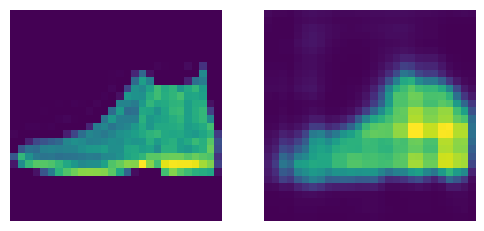

In [9]:
pred = model(xb.to(def_device))
show_images([xb[0, ...].squeeze(), pred[0, ...].squeeze()])

That looks...not great.

At this point, Jeremy points out that copying and pasting code leads to bottlenecks in modeling velocity. We need to start to build a framework to:

- rapidly try things
- figure out where things are broken
- fast data loading
- transparent CUDA device assignment

The fundamental abstraction of such an abstraction is the `Learner`. Here's a simple example that takes the loop in the `convs` notebook.

In [10]:
class SimpleLearner:
    """Adapted from: https://github.com/fastai/course22p2/blob/master/nbs/09_learner.ipynb"""

    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD):
        fc.store_attr()

    def one_batch(self):
        self.xb, self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad():
            self.calc_stats()

    def calc_stats(self):
        acc = (self.preds.argmax(dim=1) == self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss * n)
        self.ns.append(n)

    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num, self.batch in enumerate(dl):
            self.one_batch()
        n = sum(self.ns)
        print(
            self.epoch,
            self.model.training,
            sum(self.losses).item() / n,
            sum(self.accs).item() / n,
        )

    def fit(self, n_epochs):
        self.accs, self.losses, self.ns = [], [], []
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(train=True)
            with torch.no_grad():
                self.one_epoch(train=False)

This needs to be more sophisticated to incorporate the various behaviors we'll need, starting with metrics. We can use a `Metric` class to encapsulate this logic. (This is nearly identical to `torchmetics`.)

In [11]:
class Metric:
    def __init__(self):
        self.reset()

    def reset(self):
        self.vals, self.ns = [], []

    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)

    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals) * ns).sum() / ns.sum()

    def calc(self, inps, targs):
        return inps

In [12]:
class Accuracy(Metric):
    def calc(self, inps, targs):
        return (inps == targs).float().mean()

In [13]:
accuracy = Accuracy()
accuracy.add(torch.tensor([0, 1]), torch.tensor([0, 0]))
accuracy.value

tensor(0.5000)

In [14]:
# |export
Loss = Metric  # Loss is just the average of the inputs

In [15]:
loss = Loss()
loss.add(torch.tensor([0]))
loss.add(torch.tensor([2]))
loss.value

tensor(1.)

To incorporate metrics, we'll need a version of the learner with the same basic structure but with callbacks.

In [16]:
class CancelFitException(Exception):
    pass


class CancelBatchException(Exception):
    pass


class CancelEpochException(Exception):
    pass


class Callback:
    order = 0


def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=lambda x: getattr(x, "order")):
        method = getattr(cb, method_nm, None)
        if method is not None:
            method(learn)

In [17]:
class DeviceCB(Callback):
    def __init__(self, device=def_device):
        fc.store_attr()

    def before_fit(self, learn):
        if hasattr(learn.model, "to"):
            learn.model.to(self.device)

    def before_batch(self, learn):
        learn.batch = to_device(learn.batch, device=self.device)

In [18]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD):
        fc.store_attr()

    def one_batch(self):
        xb, yb = self.batch
        self.preds = self.model(xb)
        self.loss = self.loss_func(self.preds, yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)

        if isinstance(self.dls, (list, tuple)):
            trn_dl, tst_dl = self.dls
            self.dl = trn_dl if train else tst_dl
        else:
            raise ValueError

        try:
            self.callback("before_epoch")
            for self.iter, self.batch in enumerate(self.dl):
                try:
                    self.callback("before_batch")
                    self.one_batch()
                    self.callback("after_batch")
                except CancelBatchException:
                    pass
            self.callback("after_epoch")
        except CancelEpochException:
            pass

    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback("before_fit")
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback("after_fit")
        except CancelFitException:
            pass

    def callback(self, method_nm):
        run_cbs(self.cbs, method_nm, self)

Now, we need a metrics callback to consume the `Metric`s objects.

In [28]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms:
            metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics["loss"] = self.loss = Mean()

    def _log(self, d):
        print(d)

    def before_fit(self, learn):
        learn.metrics = self

    def before_epoch(self, learn):
        [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k: f"{v.compute():.3f}" for k, v in self.all_metrics.items()}
        log["epoch"] = learn.epoch
        log["train"] = "train" if learn.model.training else "eval"
        self._log(log)

    def after_batch(self, learn):
        x, y, *_ = learn.batch
        x = x.cpu()
        y = y.cpu()
        for m in self.metrics.values():
            m.update(learn.preds.cpu(), y)
        self.loss.update(learn.loss.cpu(), weight=len(x))

Finally, we subclass the learner for the reconstruction objective

In [29]:
class ReconstructionLearner(Learner):
    def one_batch(self):
        xb, _ = self.batch
        self.preds = self.model(xb)
        self.loss = self.loss_func(self.preds, xb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

In [34]:
model = get_model()
metrics = MetricsCB()
with fashion_mnist() as dls:
    learn = ReconstructionLearner(
        model,
        dls,
        F.mse_loss,
        lr=0.01,
        cbs=[metrics, DeviceCB()],
        opt_func=torch.optim.AdamW,
    )
    learn.fit(1)

{'loss': '0.039', 'epoch': 0, 'train': 'train'}
{'loss': '0.022', 'epoch': 0, 'train': 'eval'}


In [35]:
# |hide
import nbdev

nbdev.nbdev_export()